# Plot Figure 3

This notebook plots Figure 3 from the manuscript, comparing:
- Performance vs. that of a CNN
- Performance as the number of features and training points varies
- Performance as the distance between training and validation data increases

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path

import mosaiks.config as c
import mosaiks.plotting.fig_3_functions as f3
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from matplotlib import pyplot as plt
from matplotlib.transforms import Bbox
from mosaiks.utils import io

idx = pd.IndexSlice

f3.setup_plotting_context(1)

In [17]:
cnn_dir = Path(c.data_dir) / "output" / "cnn_comparison"
cnn_feat_fpath = cnn_dir / "TestSetR2_resnet152_1e5_pretrained.csv"
mosaiks_fpath = cnn_dir / "TestSetR2_mosaiks.csv"

out_fpath = Path(c.res_dir) / "figures" / "Fig3" / "Fig3.pdf"

## Aggregate CNN vs. MOSAIKS performance data

In [18]:
## load pre-trained CNN features performance
unsup = pd.read_csv(
    cnn_feat_fpath, header=None, names=["task", "cnn_feat"], index_col="task"
)

## load mosaiks performance
mosaiks = pd.read_csv(
    mosaiks_fpath,
    header=None,
    usecols=[0, 2],
    names=["task", "mosaiks"],
    skiprows=1,
    index_col="task",
)

## load CNN performance
cnn = pd.DataFrame(
    [io.load_cnn_performance(task, c) for task in c.app_order],
    index=c.app_order,
    columns=["cnn"],
)

# merge
results = cnn.join(mosaiks).join(unsup)
results = results.reindex(c.app_order)

## Plot figure

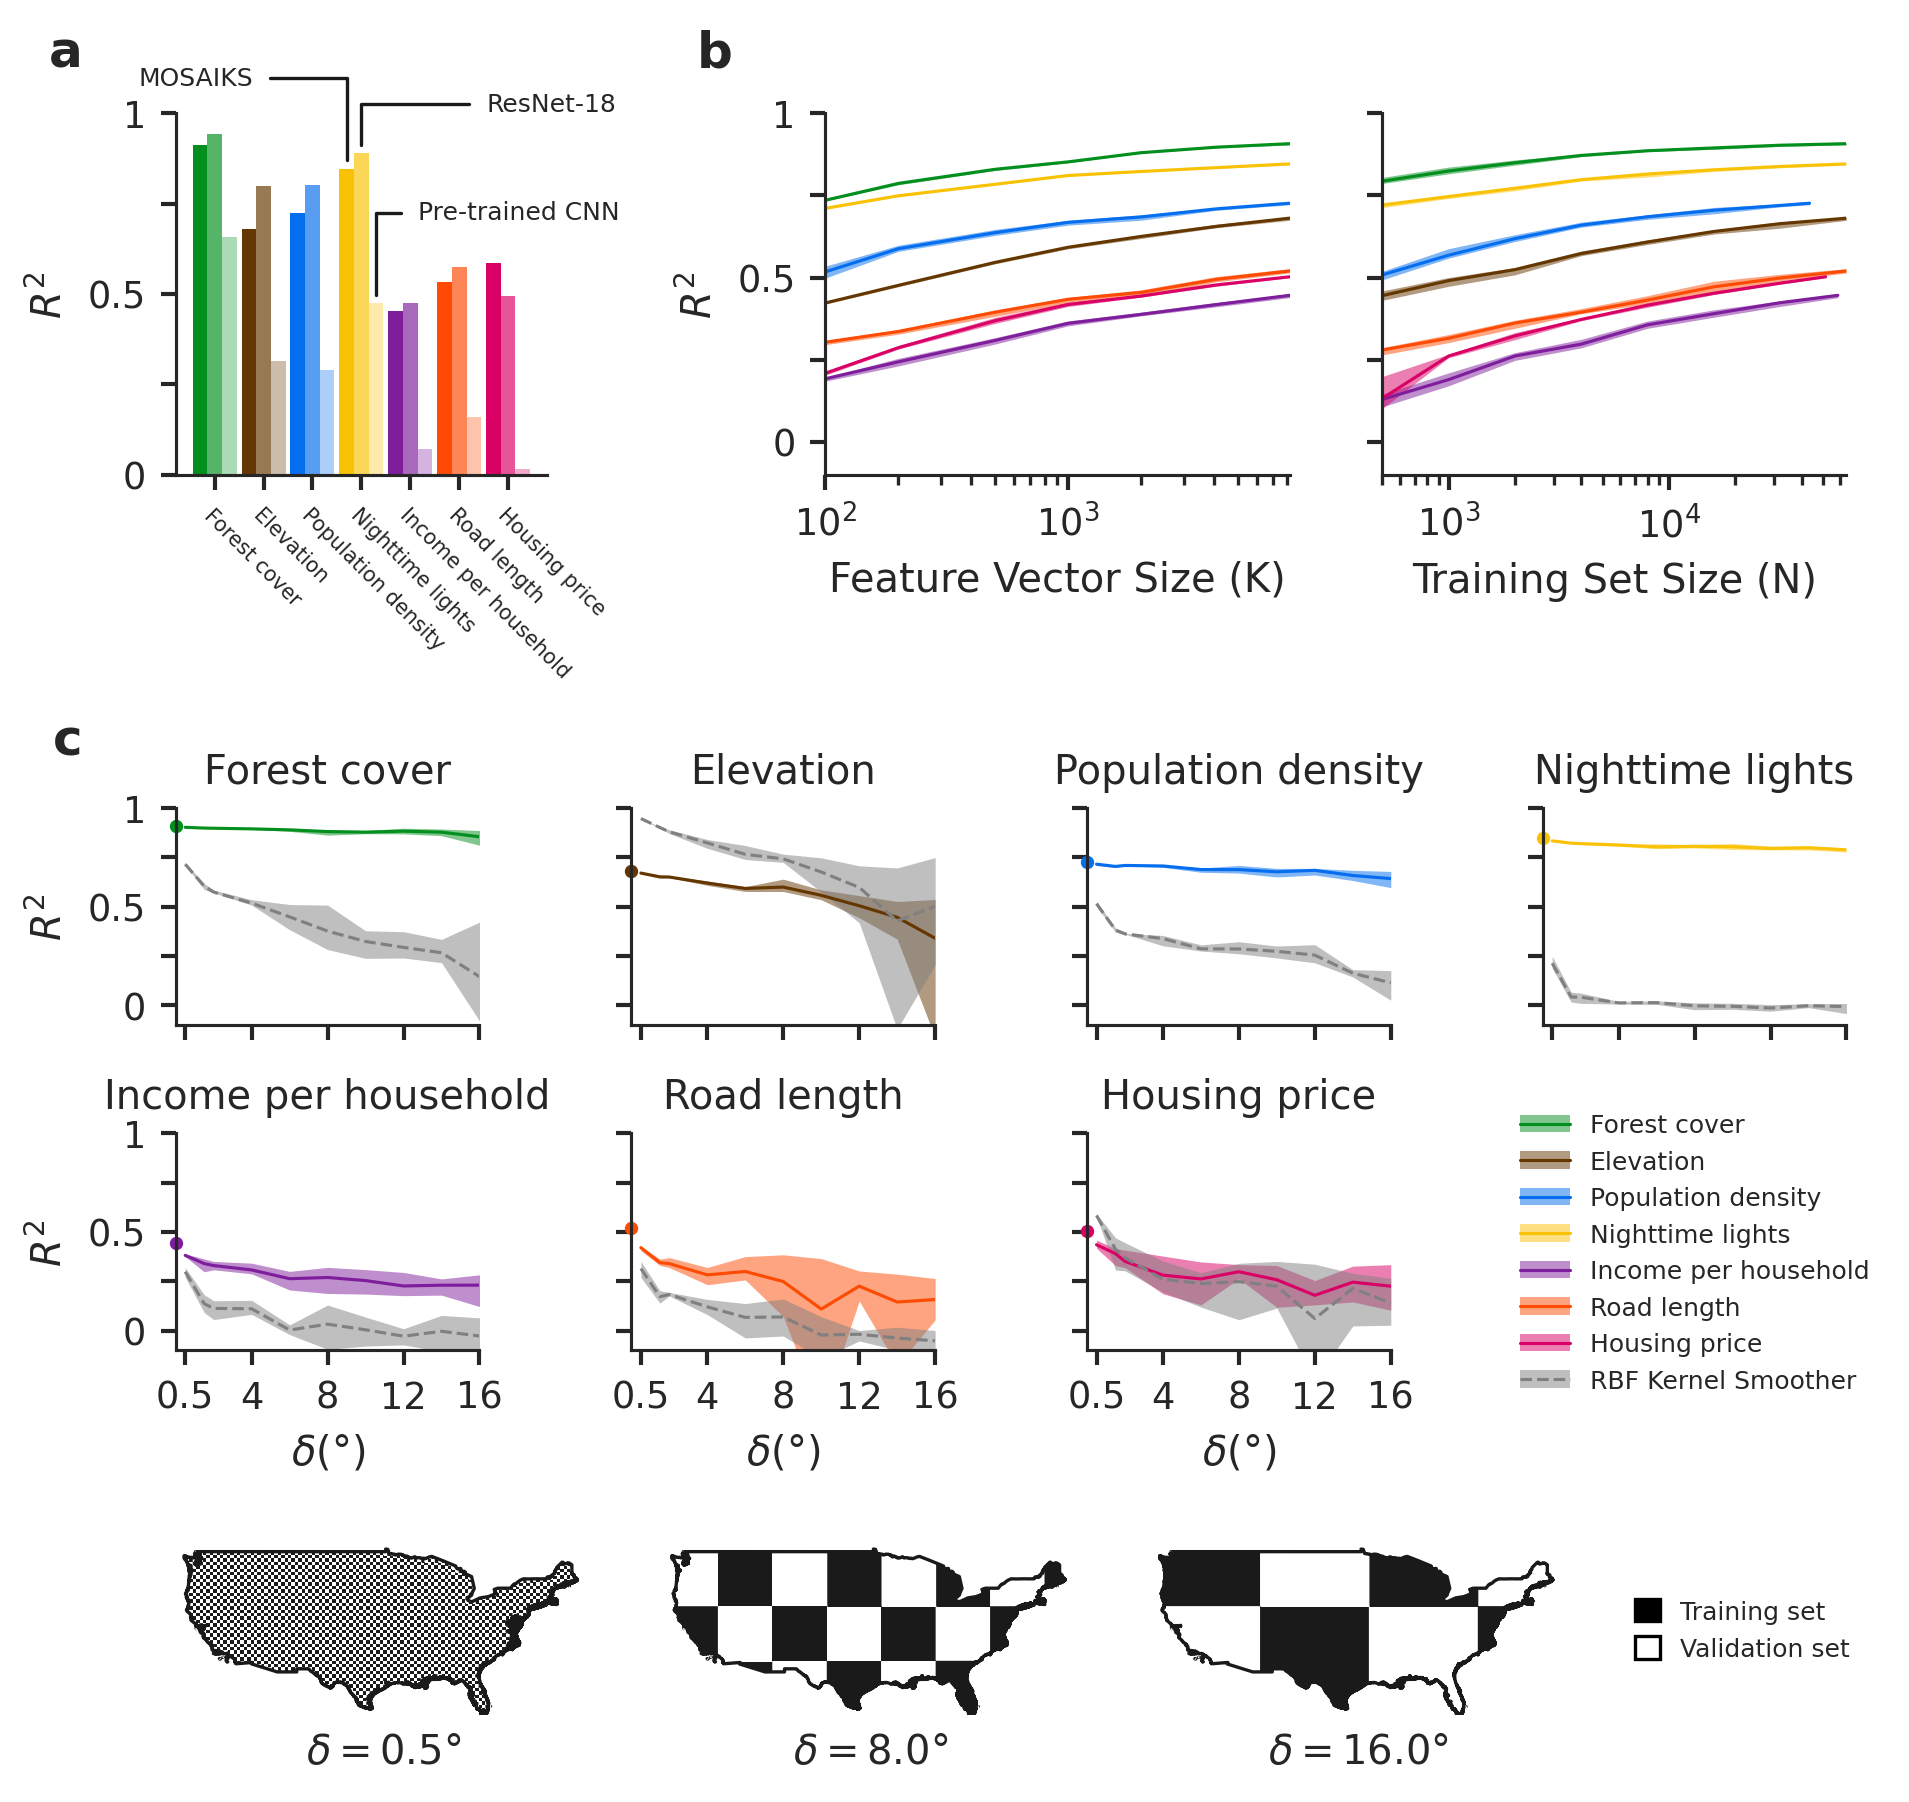

In [16]:
# setup fig with gridspec
fig = plt.figure(figsize=(6.4, 6.4), dpi=300)
gs = gridspec.GridSpec(3, 1, height_ratios=(2, 3, 1))

# get pointers to different panels
gs_top = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs[0], wspace=0.75)
gs_topright = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=gs_top[1:])
ax_topleft = plt.subplot(gs_top[0])
gs_mid = gridspec.GridSpecFromSubplotSpec(
    2, 4, subplot_spec=gs[1], hspace=0.5, wspace=0.5
)
gs_bot = gridspec.GridSpecFromSubplotSpec(
    1, 4, subplot_spec=gs[2], width_ratios=(1, 1, 1, 0.5)
)

axs_topright = []
axs_mid = []
axs_bot = []

## plot CNN results
colors = [getattr(c, app)["color"] for app in c.app_order]
labels = [getattr(c, app)["disp_name"] for app in c.app_order]

width = 0.3
x = np.arange(len(colors))  # the label locations

# plot bars
rects1 = ax_topleft.bar(
    x - width,
    results["mosaiks"],
    width,
    label="MOSAIKS",
    color=colors,
    edgecolor="none",
)
rects2 = ax_topleft.bar(
    x,
    results["cnn"],
    width,
    label="ResNet-18",
    color=colors,
    edgecolor="none",
    alpha=0.67,
)
rects2 = ax_topleft.bar(
    x + width,
    results["cnn_feat"],
    width,
    label="Pre-trained CNN",
    color=colors,
    edgecolor="none",
    alpha=0.33,
)

sns.despine(ax=ax_topleft)
ax_topleft.set_ylim(0, 1)
ax_topleft.set_ylabel("$R^2$")
ax_topleft.set_yticks(f3.YTICKS)
ax_topleft.set_yticklabels(f3.YTICKLABELS)
ax_topleft.set_xticks(x)
ax_topleft.set_xticklabels(labels)
plt.setp(
    ax_topleft.get_xticklabels(),
    rotation=315,
    ha="left",
    rotation_mode="anchor",
    fontsize="small",
)

# annotations
x_annot = (x[-1] - x[0]) / 2
y_annot = results.iloc[int((len(c.app_order) - 1) / 2)]
ax_topleft.annotate(
    "MOSAIKS",
    xy=(x_annot - width, y_annot["mosaiks"]),
    xycoords="data",
    xytext=(-50, 20),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90,rad=0", color="k"
    ),
)

ax_topleft.annotate(
    "ResNet-18",
    xy=(x_annot, y_annot["cnn"]),
    xycoords="data",
    xytext=(30, 10),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90,rad=0", color="k"
    ),
)

ax_topleft.annotate(
    "Pre-trained CNN",
    xy=(x_annot + width, y_annot["cnn_feat"]),
    xycoords="data",
    xytext=(10, 20),
    textcoords="offset points",
    arrowprops=dict(
        arrowstyle="-", connectionstyle="angle,angleA=0,angleB=90,rad=0", color="k"
    ),
)

## model map plots
handles = f3.plot_model_diagnostic_lineplots(gs_topright, axs_topright)

## checkerboard map plots
f3.plot_spatial_lineplots(gs_mid, axs_mid)

## checkerboard map plots
f3.plot_checkerboard_maps(gs_bot, axs_bot)

## add panel labels
ax_upp = axs_topright[0]
width_upp = ax_topleft.bbox.x1 - ax_topleft.bbox.x0
ax_mid = axs_mid[0]
width_mid = ax_mid.bbox.x1 - ax_mid.bbox.x0
ax_low = axs_bot[0]
width_low = ax_low.bbox.x1 - ax_low.bbox.x0

lbl = ax_topleft.text(
    -0.25,
    1.1,
    "a",
    transform=ax_topleft.transAxes,
    ha="right",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
lbl = ax_upp.text(
    -0.2,
    1.1,
    "b",
    transform=ax_upp.transAxes,
    ha="right",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)
lbl = ax_mid.text(
    -0.25 * width_upp / width_mid,
    1.2,
    "c",
    transform=ax_mid.transAxes,
    ha="right",
    va="bottom",
    fontsize=12,
    fontweight="bold",
)

## draw
fig.canvas.draw()
fig.tight_layout()

# some adjusting of the checkerboard maps location
for ax in axs_bot:
    pts = ax.get_position().get_points()
    pts[:, 1] += 0.075
    ax.set_position(Bbox(pts))

In [37]:
out_fpath.parent.mkdir(exist_ok=True, parents=True)
fig.savefig(out_fpath, dpi="figure")

# CNN to Mosaiks comparison (from results section in main text)

In [8]:
diff = results["cnn"] - results["mosaiks"]
print(np.mean(diff))
diff

0.03419839530842219


treecover      0.028265
elevation      0.118296
population     0.076422
nightlights    0.043880
income         0.021563
roads          0.041781
housing       -0.090818
dtype: float64

# Performance Loss ratios (from results section in main text)

In [9]:
# where to find the analysis data
r2_ftr_str = "r2_score_vs_featsize_" + f3.suffix
r2_trn_str = "r2_score_vs_trainsize_" + f3.suffix
r2_check_str = f3.checkerboard_str

In [10]:
# number of features
for num in [200, 1000]:
    print(f"Percentage of optimal R2 with just {num} features")
    for app in c.app_order:
        vals = f3.load_app_data(app, r2_ftr_str)
        y = np.array(vals["y_vals"])
        y_mean = y.mean(axis=0)
        x = np.array(vals["x_vals"])

        ix_num = np.argmin(np.abs(x - num))
        y_num = y_mean[ix_num]
        y_best = y_mean.max()
        rat = y_num / y_best
        print("{0}: {1:.2f}".format(app, rat))
    print()

Percentage of optimal R2 with just 200 features
treecover: 0.87
elevation: 0.70
population: 0.81
nightlights: 0.89
income: 0.55
roads: 0.65
housing: 0.58

Percentage of optimal R2 with just 1000 features
treecover: 0.94
elevation: 0.87
population: 0.92
nightlights: 0.96
income: 0.81
roads: 0.83
housing: 0.84



In [11]:
# number of training points
print("Percentage of optimal R2 with just 500 training points")
for app in c.app_order:
    vals = f3.load_app_data(app, r2_trn_str)
    y = np.array(vals["y_vals"])
    y_mean = y.mean(axis=0)
    x = np.array(vals["x_vals"])

    ix_500 = np.argmin(np.abs(x - 500))
    y_500 = y_mean[ix_500]
    y_best = y_mean.max()
    rat = y_500 / y_best
    print("{0}: {1:.2f}".format(app, rat))

Percentage of optimal R2 with just 500 training points
treecover: 0.87
elevation: 0.65
population: 0.70
nightlights: 0.85
income: 0.29
roads: 0.54
housing: 0.39


In [12]:
# distance of checkerboard square
for d in [4, 16]:
    print(f"Percentage of optimal R2 with checkerboard width of {d} degrees")
    for app in c.app_order:
        vals = f3.load_app_data(app, r2_check_str)
        widths = np.array(vals["deltas"]) * 2
        width_ix = np.argmax(widths == d)

        metrics_exam = vals["metrics"]["image_features"][width_ix]
        r2_exam = np.mean([i["r2_score"] for i in metrics_exam])

        metrics_comp = vals["metrics"]["image_features"][0]
        r2_comp = np.mean([i["r2_score"] for i in metrics_comp])
        print(f"{app}: {r2_exam/r2_comp:.2f}")
    print()

Percentage of optimal R2 with checkerboard width of 4 degrees
treecover: 0.99
elevation: 0.92
population: 0.99
nightlights: 0.98
income: 0.81
roads: 0.67
housing: 0.65

Percentage of optimal R2 with checkerboard width of 16 degrees
treecover: 0.95
elevation: 0.51
population: 0.90
nightlights: 0.95
income: 0.60
roads: 0.37
housing: 0.52



In [13]:
# mosaiks vs. interpolation
performance = {}
for d in [0.5]:
    r2s_mos = []
    r2s_interp = []
    for app in c.app_order:
        vals = f3.load_app_data(app, r2_check_str)
        widths = np.array(vals["deltas"]) * 2
        width_ix = np.argmax(widths == d)

        metrics_exam = vals["metrics"]["latlon features sigma tuned"][width_ix]
        r2_exam = np.mean([i["r2_score"] for i in metrics_exam])
        r2s_interp.append(r2_exam)

        metrics_comp = vals["metrics"]["image_features"][0]
        r2_comp = np.mean([i["r2_score"] for i in metrics_comp])
        r2s_mos.append(r2_comp)
    performance[d] = pd.DataFrame(
        {
            "r2_mosaiks": r2s_mos,
            "r2_interpolation": r2s_interp,
        },
        index=c.app_order,
    )

In [14]:
performance[0.5]

,r2_mosaiks,r2_interpolation
treecover,0.902271,0.715072
elevation,0.670130,0.946669
population,0.715384,0.515102
nightlights,0.833430,0.213033
income,0.381209,0.297961
roads,0.420441,0.314035
housing,0.435096,0.583830
